<a href="https://colab.research.google.com/github/Sh1vam/MTech/blob/master/Iris_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Internal Assessment 1 ( M.Tech AI 2025 batch)
Subject: NNDL
Time: 30 Minutes
Marks: 25
Question
Implement a Deep Neural Network (DNN) from scratch (without using high-level APIs
like model.fit or Sequential) on the Iris dataset.
Instructions:
1) Load the Iris dataset using sklearn.datasets.load_iris.
2) Preprocess:
a) One-hot encoded labels.
b) Normalize features.
c) Split into train/test.
3) Build a DNN with:
a) Input layer (4 features)
b) Two hidden layers (at least 8 neurons each, ReLU activation)
c) Output layer (3 classes, Softmax activation)
4) Implement forward pass and backpropagation manually (using only NumPy, not
PyTorch/Keras).
5) Train for 50 epochs with a suitable learning rate.
6) Print:
a) Final training accuracy
b) Final test accuracy
Bonus (5 marks):
● Implement early stopping (stop training if validation loss increases for 3 consecutive
epochs).

In [117]:
import jax.numpy as np
from jax.nn import relu, sigmoid
from jax import random

In [118]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [119]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y.reshape(-1, 1))

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_one_hot, test_size=0.2, random_state=42)

print("Preprocessing complete.")
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Preprocessing complete.
Shape of X_train: (120, 4)
Shape of y_train: (120, 3)
Shape of X_test: (30, 4)
Shape of y_test: (30, 3)


In [120]:
def initialize_parameters(input_size, hidden_size1, hidden_size2, output_size, key):

    key, subkey1 = random.split(key)
    W1 = random.normal(subkey1, (hidden_size1, input_size))
    b1 = np.zeros((hidden_size1, 1))

    key, subkey2 = random.split(key)
    W2 = random.normal(subkey2, (hidden_size2, hidden_size1))
    b2 = np.zeros((hidden_size2, 1))

    key, subkey3 = random.split(key)
    W3 = random.normal(subkey3, (output_size, hidden_size2))
    b3 = np.zeros((output_size, 1))


    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    return parameters, key

# Initialize parameters
input_size = X_train.shape[1]
hidden_size1 = 8
hidden_size2 = 8
output_size = y_train.shape[1]
key = random.PRNGKey(42)

parameters, key = initialize_parameters(input_size, hidden_size1, hidden_size2, output_size, key)

print("Parameters initialized.")
for layer, param in parameters.items():
    print(f"{layer}: {param.shape}")

Parameters initialized.
W1: (8, 4)
b1: (8, 1)
W2: (8, 8)
b2: (8, 1)
W3: (3, 8)
b3: (3, 1)


In [121]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=0, keepdims=True)) # Subtract max for numerical stability
    return exp_x / np.sum(exp_x, axis=0, keepdims=True)

In [122]:
def forward_pass(X, parameters):

    W1, b1, W2, b2, W3, b3 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2'], parameters['W3'], parameters['b3']

    # First hidden layer
    Z1 = np.dot(W1, X.T) + b1
    A1 = relu(Z1)

    # Second hidden layer
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)

    # Output layer
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)

    caches = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}

    return A3, caches

In [123]:
def compute_loss(A4, Y):

    m = Y.shape[1]
    # Compute loss
    loss = -np.sum(Y * np.log(A4 + 1e-9)) / m # prevent log(0)
    return loss

In [124]:
def backward_pass(parameters, caches, X, Y):

    m = X.shape[0] # number of examples

    A1 = caches['A1']
    A2 = caches['A2']
    A3 = caches['A3']
    W3 = parameters['W3']
    W2 = parameters['W2']
    W1 = parameters['W1']

    # Backward pass for output layer
    dZ3 = A3 - Y.T # Derivative of loss with respect to Z3
    dW3 = np.dot(dZ3, A2.T) / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m

    # Backward pass for second hidden layer
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * (A2 > 0) # Derivative of ReLU
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    # Backward pass for first hidden layer
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (A1 > 0) # Derivative of ReLU
    dW1 = np.dot(dZ1, X) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m


    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}
    return grads

In [125]:
def update_parameters(parameters, grads, learning_rate):

    W1, b1, W2, b2, W3, b3 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2'], parameters['W3'], parameters['b3']
    dW1, db1, dW2, db2, dW3, db3 = grads['dW1'], grads['db1'], grads['dW2'], grads['db2'], grads['dW3'], grads['db3']

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}

    return parameters

In [126]:
def predict(parameters, X):

    A3, caches = forward_pass(X, parameters)
    predictions = np.argmax(A3, axis=0)
    return predictions

def calculate_accuracy(parameters, X, Y):

    predictions = predict(parameters, X)
    true_labels = np.argmax(Y, axis=1)
    accuracy = np.mean(predictions == true_labels)
    return accuracy

In [127]:
def train_dnn(X_train, y_train, X_test, y_test, parameters, learning_rate=0.01, epochs=50, early_stopping_patience=3):

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    best_test_loss = float('inf')
    epochs_no_improve = 0

    # Transpose training and test data for matrix multiplication
    X_train_T = X_train.T
    y_train_T = y_train.T
    X_test_T = X_test.T
    y_test_T = y_test.T


    for i in range(epochs):
        # Forward pass
        A3_train, caches_train = forward_pass(X_train, parameters)

        # Compute loss
        train_loss = compute_loss(A3_train, y_train_T)
        train_losses.append(train_loss)

        # Backward pass
        grads = backward_pass(parameters, caches_train, X_train, y_train)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # Calculate accuracies
        train_acc = calculate_accuracy(parameters, X_train, y_train)
        train_accuracies.append(train_acc)
        test_acc = calculate_accuracy(parameters, X_test, y_test)
        test_accuracies.append(test_acc)

        # Compute test loss for early stopping
        A3_test, caches_test = forward_pass(X_test, parameters)
        test_loss = compute_loss(A3_test, y_test_T)
        test_losses.append(test_loss)

        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stopping_patience:
                print(f"Early stopping at epoch {i+1}")
                break


        # Print loss and accuracy every 10 epochs
        if i % 10 == 0:
            print(f"Epoch {i}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.4f}")

    return parameters, train_losses, test_losses, train_accuracies, test_accuracies

# Train the model
learning_rate = 0.01
epochs = 50
early_stopping_patience = 3

learned_parameters, train_losses, test_losses, train_accuracies, test_accuracies = train_dnn(X_train, y_train, X_test, y_test, parameters.copy(), learning_rate, epochs, early_stopping_patience)

print("\nTraining complete.")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

Epoch 0: Train Loss = 7.2205, Train Acc = 0.2250, Test Loss = 5.2417, Test Acc = 0.2000
Epoch 10: Train Loss = 1.1996, Train Acc = 0.4833, Test Loss = 0.9719, Test Acc = 0.4667
Epoch 20: Train Loss = 0.8398, Train Acc = 0.6167, Test Loss = 0.7487, Test Acc = 0.7000
Epoch 30: Train Loss = 0.7576, Train Acc = 0.6500, Test Loss = 0.7137, Test Acc = 0.7333
Epoch 40: Train Loss = 0.7119, Train Acc = 0.7000, Test Loss = 0.6911, Test Acc = 0.7333

Training complete.
Final Training Accuracy: 0.7000
Final Test Accuracy: 0.7333


In [128]:
train_accuracy = calculate_accuracy(learned_parameters, X_train, y_train)
print(f"Accuracy on training data: {train_accuracy:.4f}")

Accuracy on training data: 0.7000


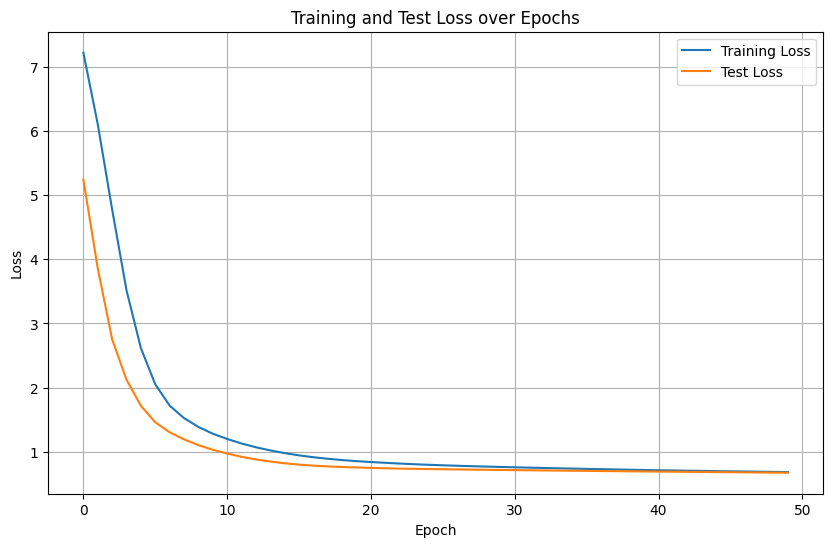

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
print("Learned Parameters:")
for layer, param in learned_parameters.items():
    print(f"{layer}:")
    display(param)

Learned Parameters:
W1:


Array([[ 0.61878276,  0.7119288 , -0.86631024, -0.58923787],
       [-1.2214384 , -0.68349963, -0.551711  , -1.3360661 ],
       [-0.07498448, -0.27546352, -0.23797537, -0.23862703],
       [ 1.2694912 ,  0.30876592,  0.3567422 , -0.32592508],
       [-0.96405536,  0.43773866, -0.438019  , -0.92647535],
       [-0.19780025,  0.5004735 , -0.39161012,  0.5488967 ],
       [-0.13023804,  0.09662059,  0.7277491 ,  1.2278248 ],
       [ 0.79052806, -1.0727439 , -0.70861334, -1.5888052 ]],      dtype=float32)

b1:


Array([[-0.07847612],
       [ 0.04524044],
       [-0.07394958],
       [-0.00588192],
       [-0.02116892],
       [-0.19546604],
       [-0.00620576],
       [ 0.00596336]], dtype=float32)

W2:


Array([[-0.37119353, -1.4817883 , -0.08319935, -1.1609802 ,  1.713326  ,
        -0.5337367 ,  0.5971065 ,  0.6457845 ],
       [ 2.8543344 , -0.950956  ,  1.2795345 , -0.52010053,  0.37899378,
         1.0066372 , -0.16291487, -0.48929957],
       [ 0.55753726, -1.9148915 ,  0.39236748, -0.90931404, -0.28234646,
         0.21757556,  0.36568996,  2.7380624 ],
       [ 0.2499688 ,  1.5494723 ,  0.37857565, -1.9037962 , -1.2366792 ,
         1.4515902 ,  0.09091887, -0.5137527 ],
       [-1.4617422 , -0.76442987,  1.6949908 ,  0.00653101, -0.00491453,
         1.0640842 , -0.1928376 , -0.420549  ],
       [-0.98941827,  2.0229824 , -1.845466  ,  0.20129302, -0.13151798,
        -0.495637  , -0.24941343, -0.33814767],
       [ 1.0137577 , -0.15916744, -0.38853937, -1.021894  , -0.9188889 ,
         0.47730815, -0.0080677 ,  0.86129326],
       [ 1.8599299 ,  0.86132705, -1.025479  ,  0.03193827,  1.2237538 ,
        -0.02837859, -0.05515801,  0.18974793]], dtype=float32)

b2:


Array([[-0.07463728],
       [-0.03485385],
       [ 0.00290589],
       [-0.10571419],
       [-0.05413526],
       [-0.04713865],
       [ 0.00045684],
       [-0.10957437]], dtype=float32)

W3:


Array([[-0.34218875, -0.19650997, -1.0992069 , -1.5212278 ,  2.4698727 ,
         0.7328895 , -0.7038619 ,  1.0375034 ],
       [ 1.8777496 ,  0.9716818 , -1.046345  ,  2.151044  ,  1.5247531 ,
        -0.03319552, -0.8009342 , -0.7155491 ],
       [ 0.71273386, -0.01092328, -0.9884129 , -2.1432366 , -0.7201246 ,
        -1.0502939 , -0.6441714 , -1.8949594 ]], dtype=float32)

b3:


Array([[-0.06859224],
       [-0.02744654],
       [ 0.09603878]], dtype=float32)